In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [1012]:
from batch_sv_system_utils import compute_eer
from batch_sv_system_utils import compute_error

In [3]:
def reduce_scores(score_list, fusion_type="avg", feat_fn=None):
    if not feat_fn:
        if fusion_type =="avg":
            return np.concatenate([score.mean(0) for score in score_list], axis=0)
        elif fusion_type =="init":
            return np.concatenate([score[0] for score in score_list], axis=0)
        elif fusion_type == "avg_std":
            return np.concatenate([score.mean(0)+score.std(0) for score in score_list], axis=0)
        elif fusion_type == "avg_max":
            return np.concatenate([score.mean(0)+score.max(0) for score in score_list], axis=0)
        else:
            raise NotImplementedError
    else:
        return np.concatenate([feat_fn(score) for score in score_list], axis=0)

## Online mode 

### Total EERs

In [215]:
eval_plda_trial_output = pickle.load(
    open("trials/eval_165/hard_enr3x30_ntar9/online_plda_score_eT10.pkl", "rb"))
eval_plda_score_list = [x[0] for x in eval_plda_trial_output]
eval_plda_labels = [x[1] for x in eval_plda_trial_output]

In [47]:
test_adapt_scores = np.concatenate([reduce_scores(x, fusion_type="init") 
                                    for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.10380144375827333, 0.10380173080231969, 0.10380115671422696, 4.669837)


In [48]:
test_adapt_scores = np.concatenate([reduce_scores(x, fusion_type="avg") 
                                    for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.03663154394893812, 0.03663135752385245, 0.036631730374023785, 4.527369817009434)


In [49]:
test_adapt_scores = np.concatenate([reduce_scores(x, fusion_type="avg_max") 
                                    for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.04158457915566705, 0.04158469468617999, 0.04158446362515411, 25.589350599127517)


In [50]:
test_adapt_scores = np.concatenate([reduce_scores(x, fusion_type="avg_std") 
                                    for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.0348589252504346, 0.03485935716518717, 0.03485849333568203, 10.839968570888322)


### Trial-wise EERs

In [67]:
test_init_scores = [reduce_scores(x, fusion_type="init") for x in eval_plda_score_list]
test_labels = eval_plda_labels
init_trial_eers = []
for scores, labels in zip(test_init_scores, test_labels):
    init_trial_eers.append(compute_eer(scores, labels)[0])

In [52]:
test_avg_scores = [reduce_scores(x, fusion_type="avg") for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_trial_eers = []
for scores, labels in zip(test_avg_scores, test_labels):
    avg_trial_eers.append(compute_eer(scores, labels)[0])

In [53]:
test_avg_max_scores = [reduce_scores(x, fusion_type="avg_max") for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_max_trial_eers = []
for scores, labels in zip(test_avg_max_scores, test_labels):
    avg_max_trial_eers.append(compute_eer(scores, labels)[0])

In [54]:
test_avg_std_scores = [reduce_scores(x, fusion_type="avg_std") for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_std_trial_eers = []
for scores, labels in zip(test_avg_std_scores, test_labels):
    avg_std_trial_eers.append(compute_eer(scores, labels)[0])

In [69]:
online_eer_df = pd.DataFrame([init_trial_eers, avg_trial_eers, avg_max_trial_eers, avg_std_trial_eers]).T
online_eer_df.columns = ["init", "avg", "avg_max", "avg_std"]
online_eer_df.index.name = "trial_idx"
online_eer_df = online_eer_df.assign(enr_spk=enr_spks)
n_adapts = [len(x) for x in eval_plda_score_list]
online_eer_df = online_eer_df.assign(n_adapt=n_adapts)

In [71]:
online_eer_df.to_pickle("trials/eval_165/hard_enr3x30_ntar9/online_plda_eers.pkl")

In [ ]:
online_eer_df

## Batch mode 

In [539]:
trials = pickle.load(open("trials/dev940_eval311/random_enr3xsess_ntar9/trials.pkl", 'rb'))

In [600]:
eval_plda_trial_output = pickle.load(
    open("trials/dev940_eval311/hard_enr3xsess_ntar9/batch_eT0.8.pkl", "rb"))

In [600]:
eval_plda_score_list = [x[0] for x in eval_plda_trial_output]
eval_plda_labels = [x[1] for x in eval_plda_trial_output]
eval_plda_confids = [x[2] for x in eval_plda_trial_output]
eval_n_adapts = [len(x[2]) for x in eval_plda_trial_output]
eval_n_false_adapts = [(1-x[3]).sum() for x in eval_plda_trial_output]
eval_plda_adapt_labels = [x[3] for x in eval_plda_trial_output]
eval_spks = [x[4].split("_")[0] for x in eval_plda_trial_output]

## Split mode 

In [1297]:
eval_plda_trial_output = pickle.load(
    open("trials/dev940_eval311/hard_enr3xsess_ntar9/proxy_eT5_small_fNorm.pkl", "rb"))

In [1298]:
n_adapt = 20
# r_idx = [0,1,2] + np.random.randint(3, 15, n_adapt-1).tolist()
eval_plda_score_list = [x[0][:n_adapt] for x in eval_plda_trial_output]
eval_plda_adapt_labels = [x[3][:n_adapt] for x in eval_plda_trial_output]
eval_plda_labels = [x[2] for x in eval_plda_trial_output]
eval_plda_proxy_score_list = [x[1][:n_adapt] for x in eval_plda_trial_output]
eval_plda_proxy_idx = [x[4][:n_adapt] for x in eval_plda_trial_output]

#### init 

In [1299]:
test_adapt_scores = np.concatenate([x[:3].mean(0) for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.08513993097596648, 0.08511485858451733, 0.08516500336741561, 2.8493434744413206)


#### including false adapt 

In [1300]:
print("with false adapt")
test_adapt_scores = np.concatenate([x.mean(0) for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))
# print(compute_error(test_adapt_scores.mean(0) > 2.19, eval_test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.max(0) for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.std(0) for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

with false adapt
(0.041540203854907344, 0.0415693564638709, 0.041511051245943786, 2.834062913556947)
(0.05456327971204601, 0.05457442570707741, 0.05455213371701462, 6.4914367108899516)
(0.04233198866653494, 0.04229576573691487, 0.042368211596155, 3.2247668019505302)


#### proxy 

In [1301]:
print("adapt_acc: base, proxy")
adapt_accs = []
proxy_adapt_accs = []
adapt_labels = [x[3] for x in eval_plda_trial_output]
for i in range(len(eval_plda_score_list)):
    adapt_accs.append(eval_plda_adapt_labels[i].mean())
    proxy_adapt_accs.append(adapt_labels[i][eval_plda_proxy_idx[i]].mean())
print(np.mean(adapt_accs))
print(np.mean(proxy_adapt_accs))

adapt_acc: base, proxy
0.8210000000000001
0.9440000000000001


In [1302]:
print("proxy adapt")
test_adapt_scores = np.concatenate([x.mean(0) for x in eval_plda_proxy_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.max(0) for x in eval_plda_proxy_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.std(0) for x in eval_plda_proxy_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

proxy adapt
(0.03617823469170213, 0.03617205745663024, 0.03618441192677402, 2.894036006818561)
(0.03603499500221896, 0.036008029556265475, 0.03606196044817245, 6.370787759189968)
(0.03535130104428209, 0.03537535051200137, 0.0353272515765628, 3.175605140915528)


#### only correct adapt 

In [1255]:
eval_plda_true_score_list = [x[0][x[3]==1][:n_adapt] for x in eval_plda_trial_output]

In [1256]:
print("with only true")
test_adapt_scores = np.concatenate([x.mean(0) for x in eval_plda_true_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))
# print(compute_error(test_adapt_scores.mean(0) > 2.19, eval_test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.max(0) for x in eval_plda_true_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

test_adapt_scores = np.concatenate([x.mean(0)+x.std(0) for x in eval_plda_true_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

with only true
(0.05469415289350306, 0.05469416503606087, 0.05469414075094525, 2.7774896767913413)
(0.051712456084588146, 0.051713334291900316, 0.05171157787727598, 5.928294628819247)
(0.05323153817788953, 0.05323162104096207, 0.05323145531481699, 3.0123771951145897)


In [ ]:
for i in range(len(eval_plda_score_list)):
    print(eval_plda_adapt_labels[i].mean())
    print(compute_eer(eval_plda_score_list[i].mean(0), eval_plda_labels[i]))
    print(eval_plda_adapt_labels[i][eval_plda_proxy_idx[i]].mean())
    print(compute_eer(eval_plda_proxy_score_list[i].mean(0), eval_plda_labels[i]))
    print()

### Trial-wise EERs

In [592]:
test_scores = [x[0] for x in eval_plda_score_list]
test_labels = eval_plda_labels
init_trial_eers = []
for scores, labels in zip(test_scores, test_labels):
    init_trial_eers.append(compute_eer(scores, labels)[0])

In [593]:
test_scores = [x.mean(0) for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_trial_eers = []
for scores, labels in zip(test_scores, test_labels):
    avg_trial_eers.append(compute_eer(scores, labels)[0])

In [594]:
test_scores = [x.mean(0)+x.max(0) for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_max_trial_eers = []
for scores, labels in zip(test_scores, test_labels):
    avg_max_trial_eers.append(compute_eer(scores, labels)[0])

In [595]:
test_scores = [x.mean(0)+x.std(0) for x in eval_plda_score_list]
test_labels = eval_plda_labels
avg_std_trial_eers = []
for scores, labels in zip(test_scores, test_labels):
    avg_std_trial_eers.append(compute_eer(scores, labels)[0])

In [596]:
batch_eer_df = pd.DataFrame([init_trial_eers, avg_trial_eers, avg_max_trial_eers, avg_std_trial_eers]).T
batch_eer_df.columns = ["init", "avg", "avg_max", "avg_std"]
batch_eer_df.index.name = "trial_idx"
batch_eer_df = batch_eer_df.assign(enr_spk=eval_spks)
batch_eer_df = batch_eer_df.assign(n_adapt=eval_n_adapts)
batch_eer_df = batch_eer_df.assign(n_false_adapt=eval_n_false_adapts)
batch_eer_df = batch_eer_df.assign(confids=eval_plda_confids)

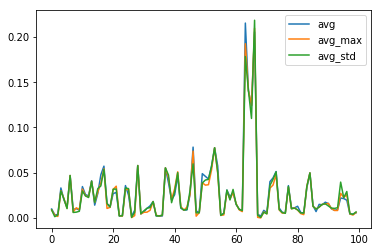

In [597]:
batch_eer_df.sort_values('enr_spk').reset_index()[["avg", "avg_max", "avg_std"]].plot()

In [598]:
batch_eer_df.groupby('enr_spk').mean()

,init,avg,avg_max,avg_std,n_adapt,n_false_adapt
enr_spk,,,,,,
id10020,0.009058,0.005670,0.004529,0.004457,153.000000,0.0
id10045,0.030178,0.026546,0.025675,0.025348,53.000000,0.0
id10096,0.023299,0.011941,0.010729,0.010280,159.000000,0.0
id10104,0.035629,0.028138,0.026690,0.026447,27.000000,0.0
id10105,0.015068,0.010208,0.011226,0.006366,2.000000,0.0
id10168,0.016109,0.008743,0.009144,0.007366,2.000000,0.0
id10203,0.061509,0.028283,0.026536,0.025564,32.666667,0.0
id10242,0.030854,0.027595,0.028798,0.028798,45.500000,0.0
id10248,0.063763,0.043999,0.040473,0.040473,12.000000,0.0


In [568]:
batch_eer_df.mean()

init               0.016674
avg                0.005725
avg_max            0.005128
avg_std            0.005598
n_adapt          220.830000
n_false_adapt      0.010000
dtype: float64

In [565]:
print(np.count_nonzero(batch_eer_df["avg"] > batch_eer_df["avg_max"]))
print(np.count_nonzero(batch_eer_df["avg"] == batch_eer_df["avg_max"]))
print(np.count_nonzero(batch_eer_df["avg"] < batch_eer_df["avg_max"]))

57
18
25


In [566]:
print(np.count_nonzero(batch_eer_df["avg"] > batch_eer_df["avg_std"]))
print(np.count_nonzero(batch_eer_df["avg"] == batch_eer_df["avg_std"]))
print(np.count_nonzero(batch_eer_df["avg"] < batch_eer_df["avg_std"]))

41
25
34


### Enrollment importance 

In [223]:
t_idx = 3
score = eval_plda_score_list[t_idx]
confids = eval_plda_confids[t_idx]

In [225]:
score.shape

(8, 2260)

###  budget

In [196]:
budget = 20

In [214]:
# sorted_adapt_idx = [np.concatenate([np.array([0,1,2]),  np.argsort(x)+3])
#                                    for x in eval_plda_confids]
sorted_adapt_idx = [np.concatenate([np.array([0,1,2]),  
                                    np.argsort(x[x>15])+3])
                                   for x in eval_plda_confids]

test_adapt_scores = np.concatenate([x[idx].mean(0) 
                                    for x, idx in 
                                    zip(eval_plda_score_list, sorted_adapt_idx)])
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.036102679606125974, 0.03610281091796501, 0.03610254829428694, 4.49718988101266)


In [213]:
test_adapt_scores = np.concatenate([x[:budget].mean(0) 
                                    for x in eval_plda_score_list], axis=0)
test_labels = np.concatenate(eval_plda_labels)
print(compute_eer(test_adapt_scores, test_labels))

(0.037581830023256005, 0.037581457004999506, 0.037582203041512496, 4.5940591699999995)


In [92]:
batch_eer_df.to_pickle("trials/eval_165/hard_enr3x30_ntar9/batch_plda_eers_eT15.pkl")

In [109]:
batch_eer_df = pd.read_pickle("trials/eval_165/hard_enr3x30_ntar9/batch_plda_eers_eT10.pkl")

In [98]:
print(np.count_nonzero(batch_eer_df["avg"] > batch_eer_df["avg_max"]))
print(np.count_nonzero(batch_eer_df["avg"] == batch_eer_df["avg_max"]))
print(np.count_nonzero(batch_eer_df["avg"] < batch_eer_df["avg_max"]))

2782
387
1781


In [100]:
batch_eer_spks = batch_eer_df.groupby("enr_spk").mean()

In [ ]:
batch_eer_spks[(batch_eer_spks["avg"] > batch_eer_spks["avg_std"]) &
               (batch_eer_spks["avg"] > batch_eer_spks["avg_max"])]

In [113]:
print(np.count_nonzero(batch_eer_spks["avg"] > batch_eer_spks["avg_max"]))
print(np.count_nonzero(batch_eer_spks["avg"] < batch_eer_spks["avg_max"]))

115
49


In [107]:
batch_eer_df[batch_eer_df["avg"] > batch_eer_df["avg_skk"]].mean()

init         0.092698
avg          0.035618
avg_max      0.027601
avg_std      0.032500
n_adapt    184.871675
dtype: float64

In [108]:
batch_eer_df[batch_eer_df["avg"] < batch_eer_df["avg_max"]].mean()

init         0.077143
avg          0.026569
avg_max      0.031920
avg_std      0.028983
n_adapt    187.673779
dtype: float64